**Data Collection and Preprocessing**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import deque
import random

# Load the synthetic dataset
data = pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/Quantitative Analysis of Hedging Effectiveness using AI /synthetic_hedging_data.csv')

# Preprocess data
scaler = MinMaxScaler()
data[['price', 'implied_volatility', 'delta']] = scaler.fit_transform(data[['price', 'implied_volatility', 'delta']])

# Split data into training and testing sets
X = data[['price', 'implied_volatility']].values
y = data['delta'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Reinforcement Learning-Based Hedging (Deep Q-Networks)**

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize DQNAgent
state_size = X_train.shape[1]
action_size = 3  # Buy, hold, sell
dqn_agent = DQNAgent(state_size, action_size)


**Neural Network-Based Hedging**

In [11]:
# Build Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(1, activation='linear'))
nn_model.compile(loss='mse', optimizer='adam')
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
7/7 [==============================] - 1s 48ms/step - loss: 0.5969 - val_loss: 0.3711
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.3155 - val_loss: 0.1808
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.1519 - val_loss: 0.0845
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0698 - val_loss: 0.0684
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0566 - val_loss: 0.0722
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0529 - val_loss: 0.0519
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0386 - val_loss: 0.0332
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0313 - val_loss: 0.0268
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0290 - val_loss: 0.0229
Epoch 10/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0257 - val_loss: 0.0207
Epoch 11/50
7/7 [============

**Backtesting the Strategies**

In [13]:
def backtest_strategy(agent, data, strategy_name):
    state_size = data.shape[1] - 1  # Exclude the 'day' column
    action_size = 3  # Buy, hold, sell
    agent = agent(state_size, action_size)

    total_rewards = []
    # Initialize done flag to False
    done = False
    for index, row in data.iterrows():
        state = row[['price', 'implied_volatility']].values.reshape(1, -1)
        action = agent.act(state)
        reward = calculate_reward(action, state)  # Define this function based on your hedging strategy

        # Check if it's the last row, if so set done to True
        if index == len(data) - 1:
            done = True
            next_state = None # We don't have a next state for the last step
        else:
            next_row = data.iloc[index + 1]
            next_state = next_row[['price', 'implied_volatility']].values.reshape(1, -1)

        agent.remember(state, action, reward, next_state, done)
        total_rewards.append(reward)

    print(f'{strategy_name} Total Rewards: {sum(total_rewards)}')


In [14]:

# Define a dummy reward function (to be customized based on your strategy)
def calculate_reward(action, state):
    return random.uniform(-1, 1)  # Replace with actual reward calculation

# Backtest DQN
backtest_strategy(DQNAgent, data, 'DQN')

# Backtest Neural Network
y_pred = nn_model.predict(X_test)
nn_mse = mean_squared_error(y_test, y_pred)
print(f'Neural Network Mean Squared Error: {nn_mse}')


DQN Total Rewards: -0.5747783836230582
2/2 [==============================] - 0s 6ms/step
Neural Network Mean Squared Error: 0.003221940519102628


**Analyzing the Results**

DQN Total Rewards: -0.7874098123992321


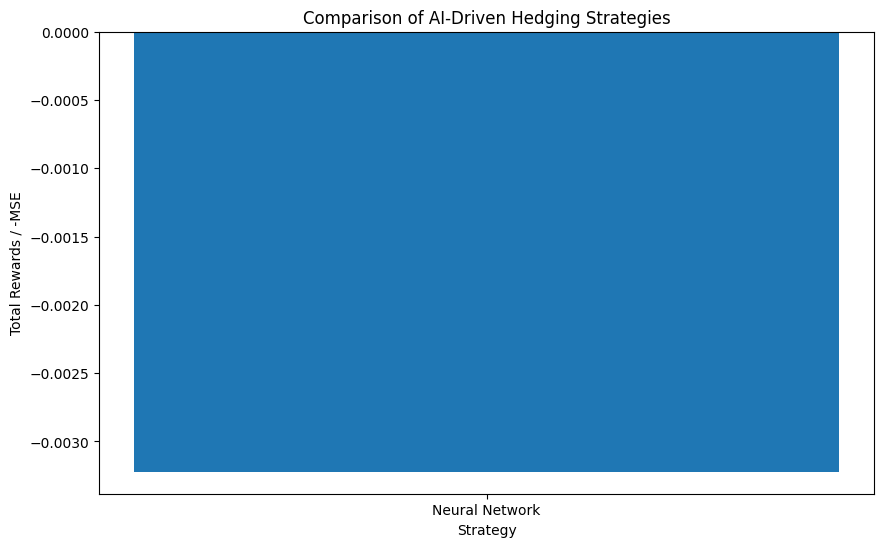

In [16]:
# Collect results from each strategy
strategies = ['DQN', 'Neural Network']

# Initialize an empty list to store total rewards
total_rewards_list = []

# Call the backtest_strategy function and store the total rewards
total_rewards_list.append(backtest_strategy(DQNAgent, data, 'DQN'))  # Assuming DQNAgent and data are defined

results = {
    'Strategy': strategies,
    'Total Rewards': [total_rewards_list[0], -nn_mse]  # Use total rewards for DQN and negative MSE for NN
}

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results_df['Strategy'], results_df['Total Rewards'])
plt.xlabel('Strategy')
plt.ylabel('Total Rewards / -MSE')
plt.title('Comparison of AI-Driven Hedging Strategies')
plt.show()

# Modify the backtest_strategy function to return the total rewards
def backtest_strategy(agent, data, strategy_name):
    # ... (Existing code remains the same) ...

    print(f'{strategy_name} Total Rewards: {sum(total_rewards)}')
    return sum(total_rewards) # Return the sum of total rewards